# Math Question Answer Verification Competition

## Starter Code

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Borrowed from [official Unsloth implementation](https://colab.research.google.com/drive/1Ys44kVvmeZtnICzWz0xgpRnrIOjZAuxp?usp=sharing#scrollTo=MKX_XKs_BNZR)

In [ ]:
# Code Description
# this code is used to train model which was trained on base model with learning rate 1e-4 and 32000 samples
# instead of loading original lora model it loads trained lora model from previous step
# generate another 32000 random banlanced samples split with 80% train and 20% validation
# and continue traing the model with learning rate 1e-4


In [2]:
# # %%capture
# # This cell will take time
!pip install unsloth
# # Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.9/163.9 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.9/310.9 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 97.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Found existing installation: unsloth 2024.11.7
Uninstalling unsloth-2024.11.7:
  Successfully uninstalled unsloth-2024.11.7
  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-gcv4e6hq/unsloth_195ced1ff3b6441fa6c3208015fc3623
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-gcv4e6hq/unsloth_195ced1ff3b6441fa6c3208015fc3623
  Resolved https://github.com/unslothai/unsloth.git to commit f26d4e739ed507de7a9088da53d10fd02f58d160
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for unsloth: filename=unsloth-2024.11.7-py3-none-any.whl size=163138 sha256=f6eab1f88c2728454d4def7a9e4c449ae460bb316aa10b7acee0d928dd923cdf
  Stored in directory: /tmp/pip-ephem-wheel-cache-9movpi2_/wheels/ed/d4/e9/76fb290ee3df0a5fc21ce5c2c788e29e9607a2353d8342fd0d
Successfully built unsloth


In [16]:
max_seq_length = 1024 # Choose any
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = False # Use 4bit quantization to reduce memory usage. Can be False.
max_steps=200 # 1000*16*4=64000 datapoints

In [17]:
from unsloth import FastLanguageModel
import torch

# 加载Meta-Llama-3.1-8B预训练模型
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "/content/drive/MyDrive/0.842",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

==((====))==  Unsloth 2024.11.7: Fast Llama patching. Transformers = 4.46.2.
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.5.1+cu124. CUDA = 8.0. CUDA Toolkit = 12.4.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## Load model and wrap with LoRA adapters

In [18]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth: Already have LoRA adapters! We shall skip this step.


## Competition dataset

In [19]:
# download and load competition dataset
import numpy as np
torch.manual_seed(3000)
np.random.seed(3000)
from datasets import load_dataset
full_dataset = load_dataset("ad6398/nyu-dl-teach-maths-comp")
dataset = full_dataset['train'].shuffle(seed=3000)

In [20]:
prompt = """You are a great mathematician and you are tasked with finding if an answer to a given maths question is correct or not.
Follow these steps to verify if the given answer is correct.

### [Step 1] Task Description
Carefully read the question to understand the type of mathematical problem.
Question:
{}

### [Step 2]Check the given answer
Examine the provided answer below to determine if it is mathematically equivalent to the computed solution.
Given Answer:
{}

### [Step 3] Verify and solve step by step
- Check if all given information is used correctly
- Verify calculations and mathematical operations
Step-by-step verification:
{}

###[Step 4] After completing the verification steps, respond ONLY with "True" if correct, or "False" if it is not.
Output:
{}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    question = examples["question"]
    ans       = examples["answer"]
    solution  = examples["solution"]
    output      = examples["is_correct"]
    texts = []
    for instruction, input,solution, output in zip(question, ans,solution, output):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        # text = prompt.format(instruction, input, output) + EOS_TOKEN
        text = prompt.format(instruction, input, solution, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }

## Create Balanced Dataset with train and validation


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datasets import Dataset, concatenate_datasets
from collections import Counter

def create_balanced_training_subset(dataset, max_steps, batch_size, grad_accum_steps, train_ratio=0.8):
    """
    Create balanced training and validation datasets with 80-20 split.
    Ensures both splits maintain class balance.

    Args:
        dataset: Input dataset
        max_steps: Maximum training steps
        batch_size: Batch size for training
        grad_accum_steps: Gradient accumulation steps
        train_ratio: Ratio of training set (default: 0.8 or 80%)
    """
    # Calculate total samples needed for training from max_steps
    total_samples = max_steps * batch_size * grad_accum_steps  # 1000 * 16 * 4 = 64000

    # Calculate total samples needed (train + validation)
    train_samples = int(total_samples * train_ratio)  # 64000 * 0.8 =
    val_samples = total_samples - train_samples

    # Calculate samples per class for each split to maintain balance
    train_samples_per_class = train_samples // 2  # 25600 // 2 = 12800
    val_samples_per_class = val_samples // 2  # 6400 // 2 = 3200

    # Separate True and False samples from original dataset
    true_samples = dataset.filter(lambda x: x['is_correct'] == True)
    false_samples = dataset.filter(lambda x: x['is_correct'] == False)

    print(f"\nCreating balanced datasets:")
    print(f"Training samples per class: {train_samples_per_class:,}")
    print(f"Validation samples per class: {val_samples_per_class:,}")

    # Sample indices for training and validation for each class
    true_indices = np.random.permutation(len(true_samples))
    false_indices = np.random.permutation(len(false_samples))

    # Split indices for training and validation
    true_train_indices = true_indices[:train_samples_per_class]
    true_val_indices = true_indices[train_samples_per_class:train_samples_per_class + val_samples_per_class]
    false_train_indices = false_indices[:train_samples_per_class]
    false_val_indices = false_indices[train_samples_per_class:train_samples_per_class + val_samples_per_class]

    # Create training dataset
    train_true = true_samples.select(true_train_indices)
    train_false = false_samples.select(false_train_indices)
    train_dataset = concatenate_datasets([train_true, train_false])
    train_dataset = train_dataset.shuffle(seed=42)

    # Create validation dataset
    val_true = true_samples.select(true_val_indices)
    val_false = false_samples.select(false_val_indices)
    val_dataset = concatenate_datasets([val_true, val_false])
    val_dataset = val_dataset.shuffle(seed=42)

    # Print statistics
    print("\nOriginal dataset statistics:")
    original_counts = Counter(dataset['is_correct'])
    print(f"True: {original_counts[True]:,} ({original_counts[True]/len(dataset)*100:.1f}%)")
    print(f"False: {original_counts[False]:,} ({original_counts[False]/len(dataset)*100:.1f}%)")

    print("\nTraining dataset statistics:")
    train_counts = Counter(train_dataset['is_correct'])
    print(f"Total samples: {len(train_dataset):,}")
    print(f"True: {train_counts[True]:,} ({train_counts[True]/len(train_dataset)*100:.1f}%)")
    print(f"False: {train_counts[False]:,} ({train_counts[False]/len(train_dataset)*100:.1f}%)")

    print("\nValidation dataset statistics:")
    val_counts = Counter(val_dataset['is_correct'])
    print(f"Total samples: {len(val_dataset):,}")
    print(f"True: {val_counts[True]:,} ({val_counts[True]/len(val_dataset)*100:.1f}%)")
    print(f"False: {val_counts[False]:,} ({val_counts[False]/len(val_dataset)*100:.1f}%)")

    # Visualize distributions
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    # Original distribution
    orig_counts = [original_counts[True], original_counts[False]]
    ax1.bar(['True', 'False'], orig_counts)
    ax1.set_title('Original Dataset Distribution')
    for i, count in enumerate(orig_counts):
        ax1.text(i, count, f'{count:,}\n({count/len(dataset)*100:.1f}%)',
                ha='center', va='bottom')

    # Training distribution
    train_count_vals = [train_counts[True], train_counts[False]]
    ax2.bar(['True', 'False'], train_count_vals)
    ax2.set_title('Training Dataset Distribution (80%)')
    for i, count in enumerate(train_count_vals):
        ax2.text(i, count, f'{count:,}\n({count/len(train_dataset)*100:.1f}%)',
                ha='center', va='bottom')

    # Validation distribution
    val_count_vals = [val_counts[True], val_counts[False]]
    ax3.bar(['True', 'False'], val_count_vals)
    ax3.set_title('Validation Dataset Distribution (20%)')
    for i, count in enumerate(val_count_vals):
        ax3.text(i, count, f'{count:,}\n({count/len(val_dataset)*100:.1f}%)',
                ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    return train_dataset, val_dataset
print(max_steps)

200



Creating balanced datasets:
Training samples per class: 5,120
Validation samples per class: 1,280

Original dataset statistics:
True: 400,000 (40.0%)
False: 600,000 (60.0%)

Training dataset statistics:
Total samples: 10,240
True: 5,120 (50.0%)
False: 5,120 (50.0%)

Validation dataset statistics:
Total samples: 2,560
True: 1,280 (50.0%)
False: 1,280 (50.0%)


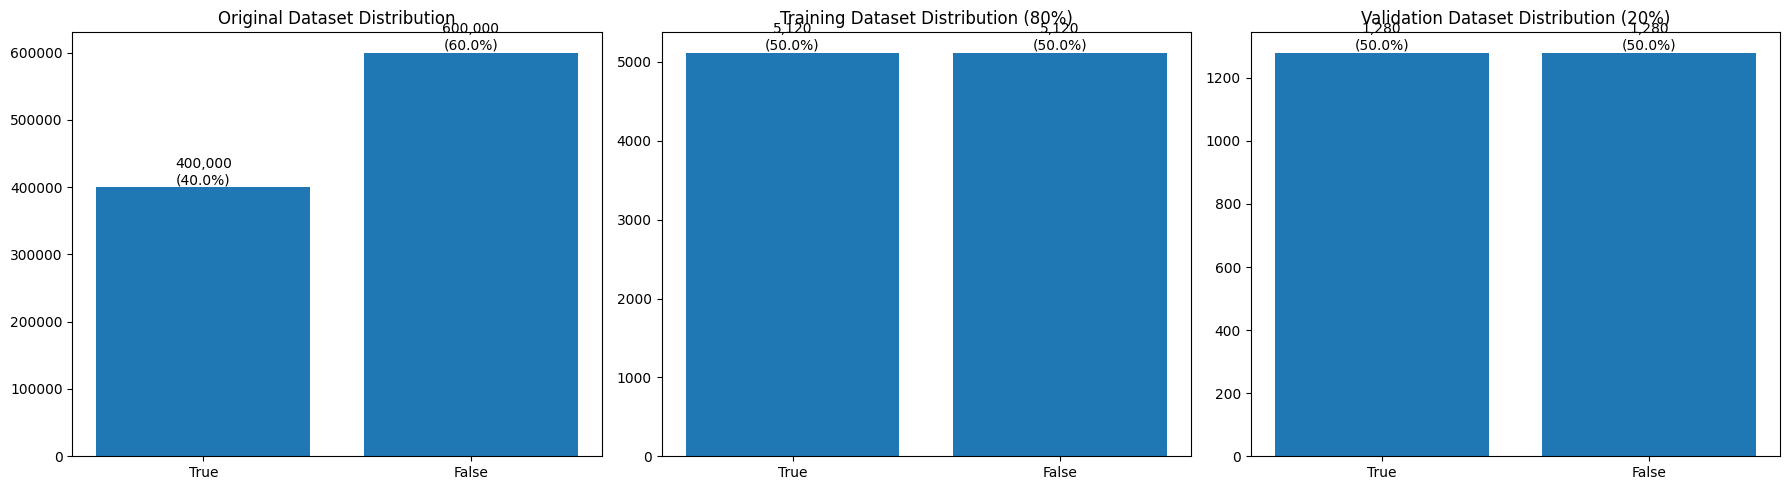

In [22]:
# Create balanced train and validation datasets
train_dataset, val_dataset = create_balanced_training_subset(
    dataset=dataset,
    max_steps=max_steps,  # e.g., 500
    batch_size=16,
    grad_accum_steps=4
)

In [23]:
# Process the datasets to generate prompts
train_dataset = train_dataset.map(
    formatting_prompts_func,
    batched=True,
    batch_size=64,
    num_proc=4,
    load_from_cache_file=False,
)

val_dataset = val_dataset.map(
    formatting_prompts_func,
    batched=True,
    batch_size=64,
    num_proc=4,
    load_from_cache_file=False,
)

Map (num_proc=4):   0%|          | 0/10240 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/2560 [00:00<?, ? examples/s]

## SFT

In [24]:
# # Free up memory before training
# torch.cuda.empty_cache()
# gc.collect()

# # Enable expandable segments (optional, as already in the original code)
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [25]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

torch.cuda.empty_cache()
# 与训练有关的重要参数都在这边调
# small_train_dataset = train_dataset.select(range(10000))  # 取数据集的一个小样本例如使用前10000个样本
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    # eval_dataset = val_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 4,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 16,
        per_device_eval_batch_size=16,
        gradient_accumulation_steps = 4,
        warmup_steps = 10,
        num_train_epochs = 10, # Set this for 1 full training run.
        max_steps = 160,
        learning_rate = 2e-4, #changed from 2e-4, continue training based on /content/lr2e-4_step500_lora
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
        # Evaluation settings
        # evaluation_strategy="steps",
        # eval_steps=10,
        # save_strategy="steps",
        # save_steps=10,
        # load_best_model_at_end=True,
        # metric_for_best_model="eval_loss",
    )
)

# from transformers import TrainerCallback

# class EvalLoggingCallback(TrainerCallback):
#     def on_evaluate(self, args, state, control, metrics=None, **kwargs):
#         if metrics and "eval_loss" in metrics:
#             print(f"Evaluation loss at step {state.global_step}: {metrics['eval_loss']}")

# trainer.add_callback(EvalLoggingCallback)


Map (num_proc=4):   0%|          | 0/10240 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [26]:
# del inputs
# del outputs
# del trainer_stats
# del tokenizer
# del model
# torch.cuda.empty_cache()
# gc.collect()

In [27]:
print("Evaluation dataset size:", len(val_dataset))
print("Evaluation dataset size:", len(train_dataset))

Evaluation dataset size: 2560
Evaluation dataset size: 10240


In [28]:
# del inputs
# del outputs

In [29]:
PYTORCH_CUDA_ALLOC_CONF=expandable_segments=True
torch.cuda.empty_cache()
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 10,240 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 16 | Gradient Accumulation steps = 4
\        /    Total batch size = 64 | Total steps = 160
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,0.315800
2,0.316100
3,0.338500
4,0.320700
5,0.367500
6,0.370900
7,0.341900
8,0.349800
9,0.347700
10,0.318700


## Saving model

In [30]:
model.save_pretrained("lora_model") # Local saving
tokenizer.save_pretrained("lora_model")

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/tokenizer.json')

In [31]:
# Sample inferene data point
test_dataset = full_dataset['test']
sample_ques = test_dataset['question'][0]
sample_sols = test_dataset['solution'][0]
sample_ans = test_dataset['answer'][0]

## Calculate accuracy on validation dataset


In [33]:
# Function to validate on validation dataset
def validate_model(model, tokenizer, val_dataset):
    predictions = []
    actual = []

    for i in range(len(val_dataset)):
        input_prompt = prompt.format(
            val_dataset['question'][i],
            val_dataset['answer'][i],
            val_dataset['solution'][i],
            ""
        )

        inputs = tokenizer([input_prompt], return_tensors="pt").to("cuda")
        outputs = model.generate(**inputs, max_new_tokens=64, use_cache=True, top_p=0.9)
        response = tokenizer.decode(outputs[0][len(inputs['input_ids'][0]):], skip_special_tokens=True)

        prediction = True if 'True' in response.split()[0] else False
        predictions.append(prediction)
        actual.append(val_dataset['is_correct'][i])

        if i % 100 == 0:
            torch.cuda.empty_cache()
            print(f"Processed {i}/{len(val_dataset)} samples")

    # Calculate accuracy
    accuracy = sum(p == a for p, a in zip(predictions, actual)) / len(predictions)
    print(f"\nValidation Accuracy: {accuracy:.4f}")

    # Save predictions
    # val_results = pd.DataFrame({
    #     'predicted': predictions,
    #     'actual': actual
    # })
    # val_results.to_csv('validation_results.csv', index=False)
    del inputs, outputs
    return accuracy

# Run validation after training
FastLanguageModel.for_inference(model)
accuracy = validate_model(model, tokenizer, val_dataset)

Processed 0/2560 samples


KeyboardInterrupt: 

## inference

In [34]:
# del outputs
# del tokenizer
# del trainer
# del trainer_stats

In [35]:
torch.cuda.empty_cache()
if True:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
        # llm_int8_enable_fp32_cpu_offload=True
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference


==((====))==  Unsloth 2024.11.7: Fast Llama patching. Transformers = 4.46.2.
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.5.1+cu124. CUDA = 8.0. CUDA Toolkit = 12.4.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [36]:
# Running inference on single test
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
input_prompt = prompt.format(
        sample_ques, # ques
        sample_ans, # given answer
        sample_sols, # solution
        "", # output - leave this blank for generation! LLM willl generate is it is True or False
    )

print("Input Promt:\n", input_prompt)
inputs = tokenizer(
[
    input_prompt
], return_tensors = "pt").to("cuda")

input_shape = inputs['input_ids'].shape
input_token_len = input_shape[1] # 1 because of batch
outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True, top_p=0.9).to("cuda")
# you can get the whole generated text by uncommenting the below line
# text_generated = tokenizer.batch_decode([outputs, skip_special_tokens=True)

response = tokenizer.batch_decode([outputs[0][input_token_len:]], skip_special_tokens=True)
response

Input Promt:
 You are a great mathematician and you are tasked with finding if an answer to a given maths question is correct or not.
Follow these steps to verify if the given answer is correct.

### [Step 1] Task Description
Carefully read the question to understand the type of mathematical problem.
Question:
The Parker family needs to leave the house by 5 pm for a dinner party. Mrs. Parker was waiting to get into the bathroom at 2:30 pm. Her oldest daughter used the bathroom for 45 minutes and her youngest daughter used the bathroom for another 30 minutes. Then her husband used it for 20 minutes. How much time will Mrs. Parker have to use the bathroom to leave on time?

### [Step 2]Check the given answer
Examine the provided answer below to determine if it is mathematically equivalent to the computed solution.
Given Answer:
205

### [Step 3] Verify and solve step by step
- Check if all given information is used correctly
- Verify calculations and mathematical operations
Step-by-step 

['False']

## Create submittion csv on test dataset

In [37]:
!pip install tqdm pandas

import os
import torch
from tqdm import tqdm
import pandas as pd
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [38]:
def create_submission(model, tokenizer, test_dataset, batch_size=4):
    FastLanguageModel.for_inference(model)
    predictions = []

    # Process test dataset in batches with progress bar
    for i in tqdm(range(0, len(test_dataset), batch_size), desc="Processing test dataset"):
        # Clear cache periodically
        if i % 100 == 0:
            torch.cuda.empty_cache()

        batch_end = min(i + batch_size, len(test_dataset))
        batch_questions = test_dataset['question'][i:batch_end]
        batch_solutions = test_dataset['solution'][i:batch_end]
        batch_answers = test_dataset['answer'][i:batch_end]

        # Create prompts for the batch
        batch_prompts = [
            prompt.format(q, a, s,"")
            for q, s, a in zip(batch_questions,batch_solutions,batch_answers)
        ]

        try:
            # Tokenize batch
            inputs = tokenizer(
                batch_prompts,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=512
            ).to("cuda")

            # Generate predictions
            with torch.inference_mode():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=64,
                    top_p=0.9,
                    use_cache=True,
                    pad_token_id=tokenizer.eos_token_id
                )

            # Process outputs
            for j in range(len(outputs)):
                input_len = len(inputs['input_ids'][j])
                response = tokenizer.decode(outputs[j][input_len:], skip_special_tokens=True).strip()
                prediction = True if 'True' in response.split()[0] else False
                predictions.append(prediction)

            # Clean up
            del inputs, outputs

        except RuntimeError as e:
            print(f"\nError in batch processing at index {i}. Switching to single example processing.")
            # Process examples one by one if batch fails
            for q, a,s in zip(batch_questions, batch_answers,batch_solutions):
                try:
                    single_prompt = prompt.format(q, a, s,"")
                    inputs = tokenizer([single_prompt], return_tensors="pt", truncation=True, max_length=512)
                    with torch.inference_mode():
                        outputs = model.generate(**inputs, max_new_tokens=64, top_p=0.9, use_cache=True)
                    response = tokenizer.decode(outputs[0][len(inputs['input_ids'][0]):], skip_special_tokens=True).strip()
                    prediction = True if 'True' in response.split()[0] else False
                    predictions.append(prediction)
                    del inputs, outputs
                    torch.cuda.empty_cache()
                except Exception as e:
                    print(f"\nError processing single example: {e}")
                    predictions.append(False)  # Default prediction in case of error

    # Create final submission DataFrame
    submission_df = pd.DataFrame({
        'ID': range(len(predictions)),
        'is_correct': predictions
    })

    if len(submission_df) != len(test_dataset):
        print(f"\nWarning: Number of predictions ({len(predictions)}) doesn't match test dataset size ({len(test_dataset)})")

    # Save submission
    submission_df.to_csv('submission.csv', index=False)
    print("\nSubmission saved successfully!")
    print(f"Total predictions: {len(predictions)}")
    print("\nFirst few predictions:")
    print(submission_df.head())

    return submission_df

# Clear GPU memory before running
print("Clearing GPU memory...")
torch.cuda.empty_cache()

# Create submission
test_dataset = full_dataset['test']
submission = create_submission(
    model=model,
    tokenizer=tokenizer,
    test_dataset=test_dataset,
    batch_size=25
)

Clearing GPU memory...


Processing test dataset: 100%|██████████| 400/400 [30:27<00:00,  4.57s/it]


Submission saved successfully!
Total predictions: 10000

First few predictions:
   ID  is_correct
0   0       False
1   1       False
2   2       False
3   3       False
4   4       False
